<a href="https://colab.research.google.com/github/ben900926/Plant-seedling-classification/blob/main/Plant_github_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import os
from pathlib import Path
from glob import glob
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.preprocessing import image
import random
import tensorflow as tf

In [29]:
from google.colab import drive 
drive.mount('/content/drive')
root = '/content/drive/MyDrive/AI_FinalProject/plant-seedlings-classification-dataset/train'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
p = Path(root)
dirs = p.glob("*")
labels_dict = {'Loose Silky-bent': 0, 'Shepherds Purse': 1, 'Scentless Mayweed': 2, 'Common Chickweed': 3, 'Fat Hen': 4, 'Common wheat': 5, 'Sugar beet': 6, 'Black-grass': 7, 'Cleavers': 8, 'Small-flowered Cranesbill': 9, 'Charlock': 10, 'Maize': 11}

image_data = []
labels = []    

for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1]
    for img_path in glob(str(folder_dir) + "/*.png"):
        img = image.load_img(img_path, target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

In [31]:
combine = list(zip(image_data, labels))

random.shuffle(combine)

image_data, labels = zip(*combine)

nTraining = int(len(image_data)*0.9)
image_data, val_data = image_data[:nTraining], image_data[nTraining:]
labels, val_labels = labels[:nTraining], labels[nTraining:]

In [32]:
test_path = Path('/content/drive/MyDrive/AI_FinalProject/plant-seedlings-classification-dataset/test')
test_names = []
test_image_data = []

for img_path in glob(str(test_path) + "/*.png"):
    image_name = str(img_path).split("/")[-1]
    test_names.append(image_name)
    img = image.load_img(img_path, target_size=(32,32))
    img_array = image.img_to_array(img)
    test_image_data.append(img_array)

In [33]:
print(len(image_data), len(val_data))
print(len(labels), len(val_labels))
print(len(test_image_data))

4281 476
4281 476
794


In [34]:
image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)

print(image_data.shape, labels.shape)

(4281, 32, 32, 3) (4281,)


In [35]:
val_data = np.array(val_data, dtype='float32')/255.0
val_labels = np.array(val_labels)

print(val_data.shape, val_labels.shape)

(476, 32, 32, 3) (476,)


In [36]:
## Convert data into numpy array
test_image_data = np.array(test_image_data, dtype='float32')/255.0

print(test_image_data.shape)

(794, 32, 32, 3)


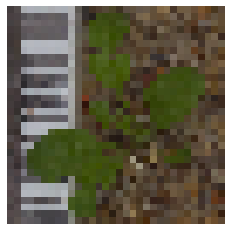

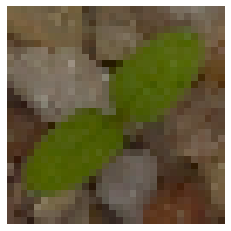

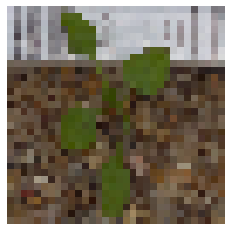

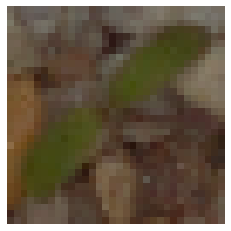

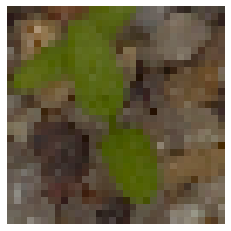

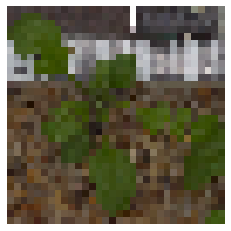

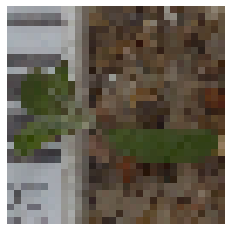

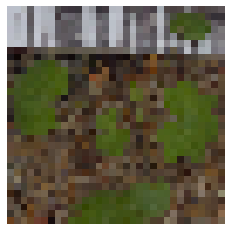

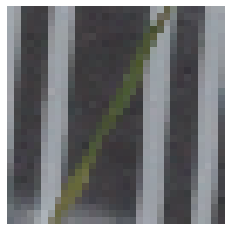

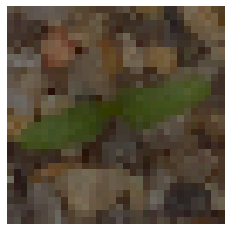

In [37]:
## Visualize the data

def drawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

for i in range(10):
    drawImg(image_data[i])

In [38]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

In [39]:
## Data conversion for One vs One classification

M = image_data.shape[0]
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(4281, 3072)
(4281,)


In [40]:
M = val_data.shape[0]
val_data = val_data.reshape(M,-1)
print(val_data.shape)
print(val_labels.shape)

(476, 3072)
(476,)


In [41]:
M = test_image_data.shape[0]
test_image_data = test_image_data.reshape(M,-1)
print(test_image_data.shape)

(794, 3072)


In [42]:
number_of_classes = len(np.unique(labels))
number_of_classes

12

In [43]:
def classWiseData(x, y):
    data = {}
    
    for i in range(number_of_classes):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [44]:
data = classWiseData(image_data, labels)

In [45]:
print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])
print(data[3].shape[0])

584
210
479
553


In [46]:
"""Combines data of two classes into a single matrix"""
def getDataPairForSVM(d1,d2):
    
    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data_pair, data_labels

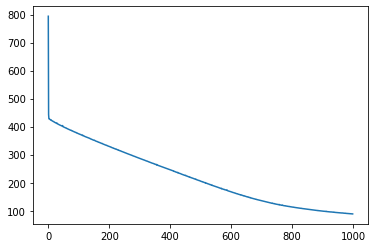

In [47]:
mySVM = SVM()
xp, yp = getDataPairForSVM(data[0], data[1])
w,b,loss = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
plt.plot(loss)

In [48]:
def trainSVMs(x,y):
    svm_classifiers = {}
    
    for i in tqdm(range(number_of_classes)):
        svm_classifiers[i] = {}
        for j in range(i+1, number_of_classes):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair, ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            
    return svm_classifiers

tf.keras code in this scope will run on GPU


  0%|          | 0/12 [00:00<?, ?it/s]

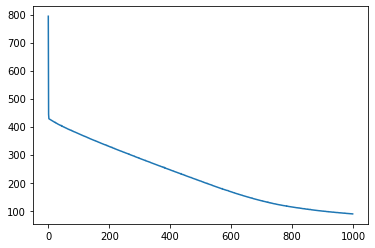

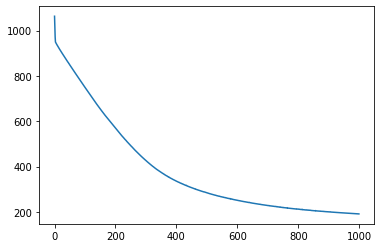

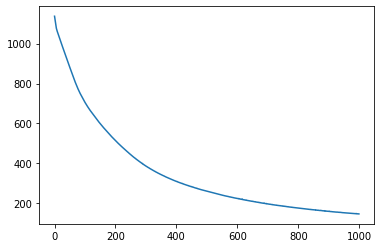

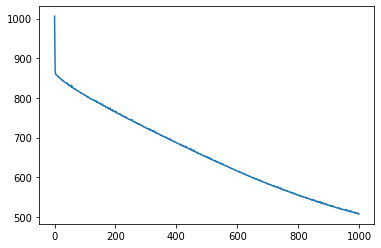

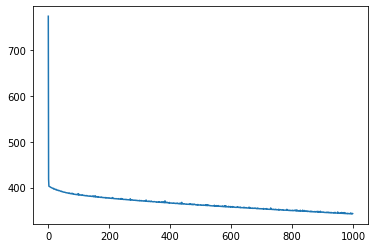

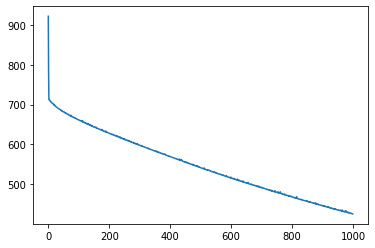

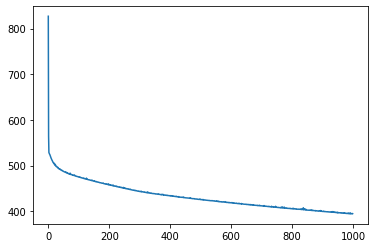

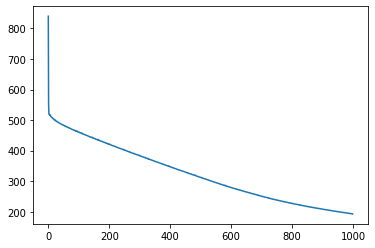

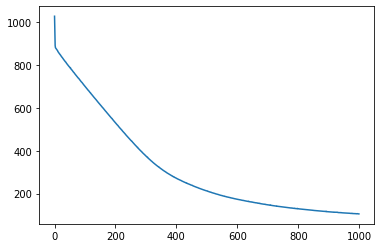

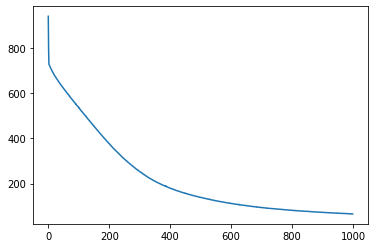

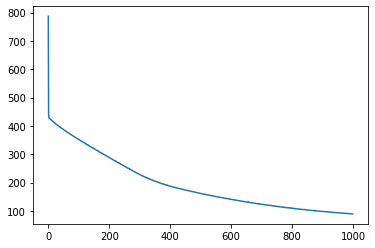

  8%|▊         | 1/12 [04:19<47:32, 259.29s/it]

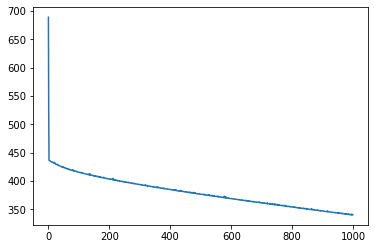

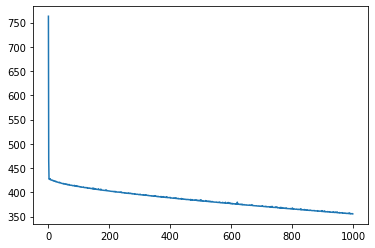

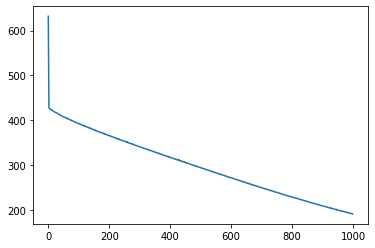

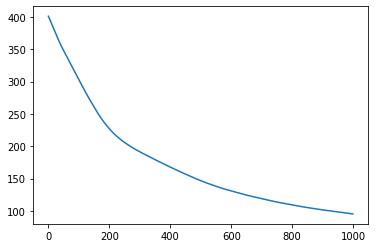

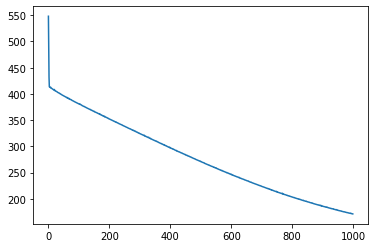

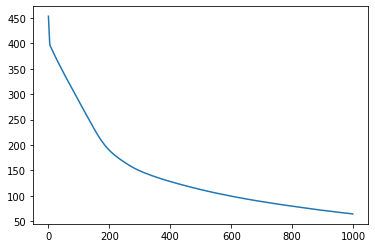

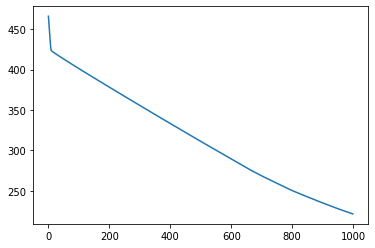

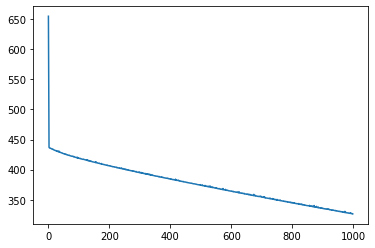

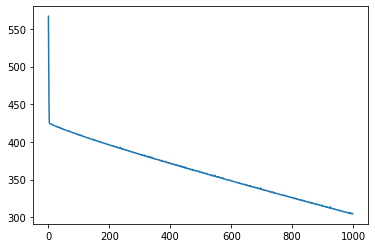

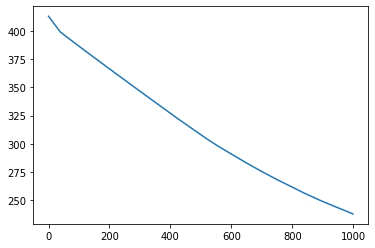

 17%|█▋        | 2/12 [06:34<31:01, 186.14s/it]

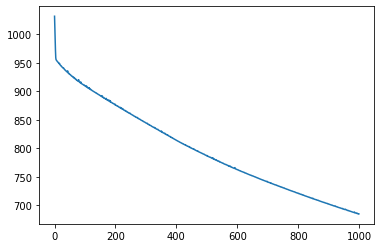

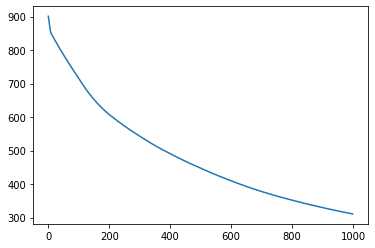

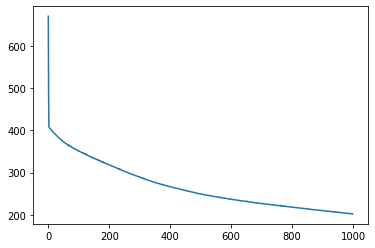

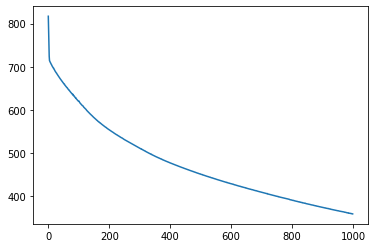

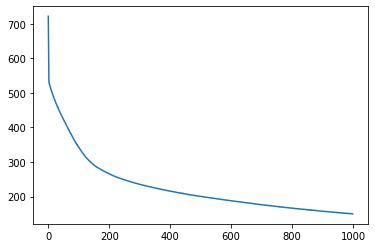

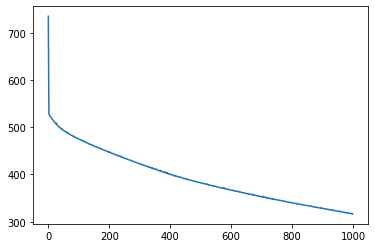

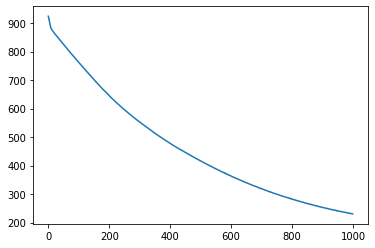

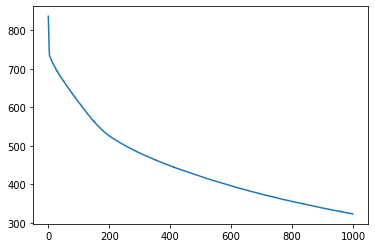

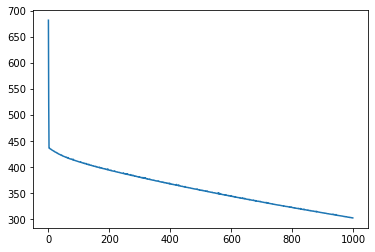

 25%|██▌       | 3/12 [09:35<27:34, 183.83s/it]

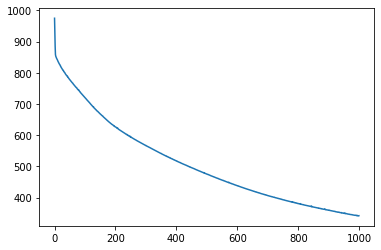

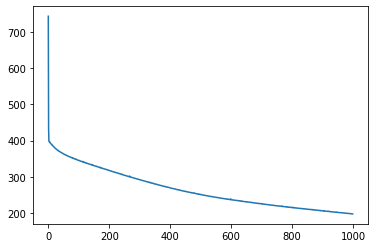

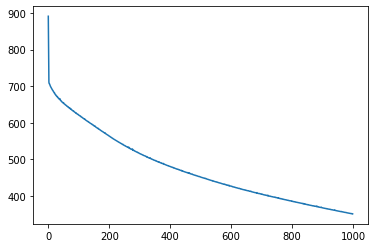

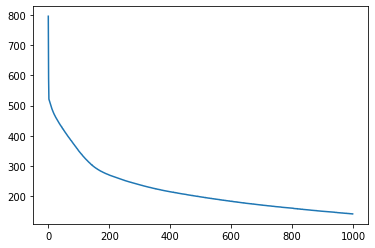

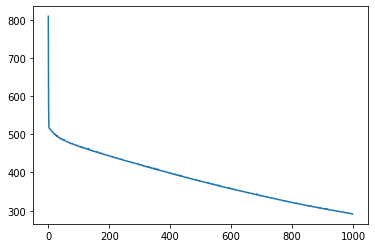

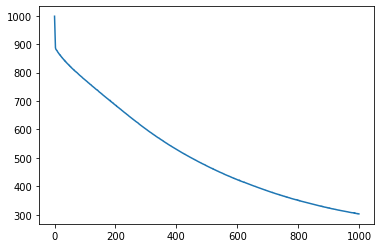

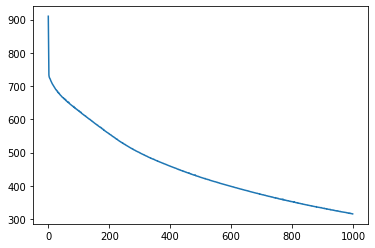

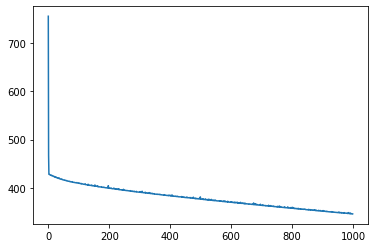

 33%|███▎      | 4/12 [12:28<23:56, 179.56s/it]

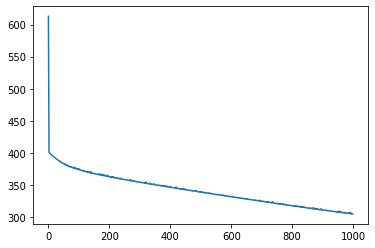

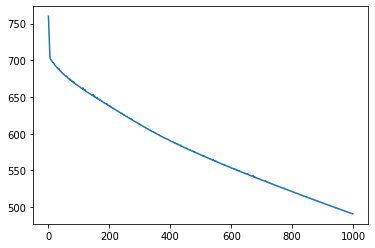

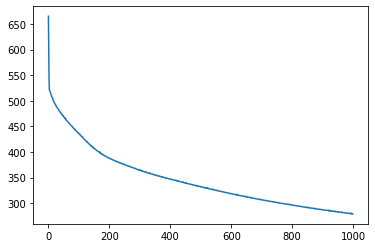

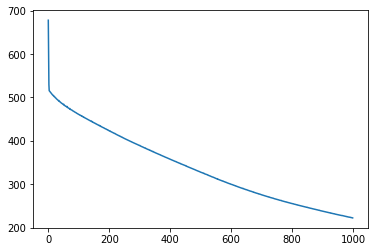

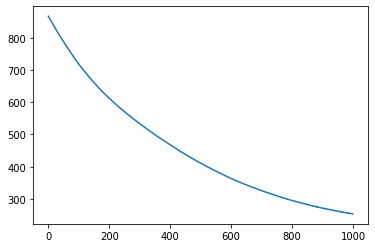

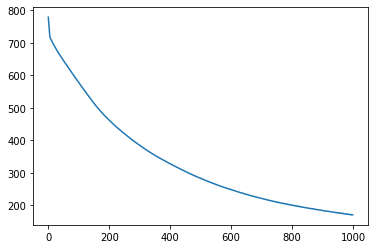

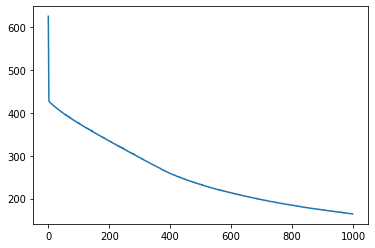

 42%|████▏     | 5/12 [14:34<18:42, 160.40s/it]

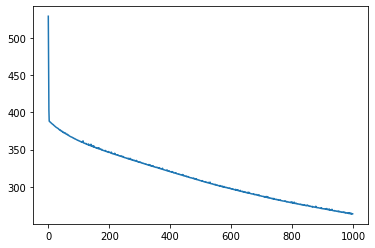

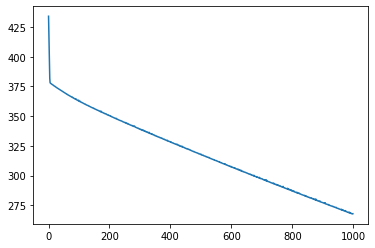

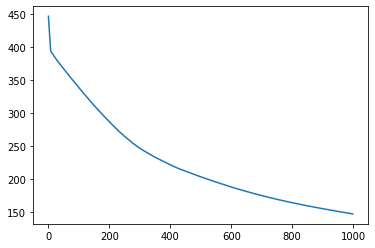

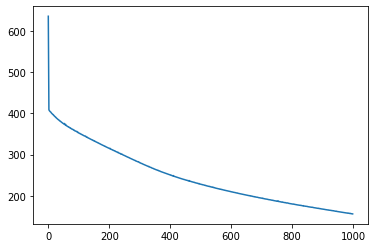

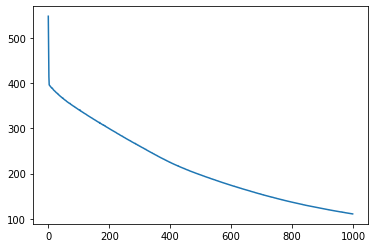

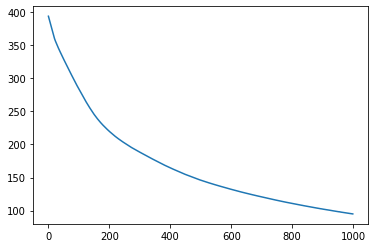

 50%|█████     | 6/12 [15:48<13:05, 130.91s/it]

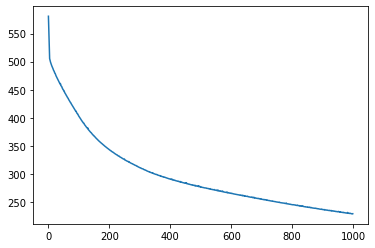

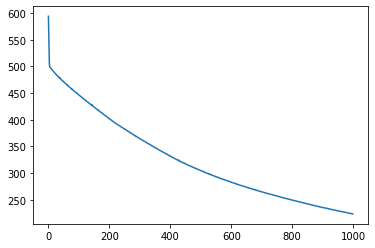

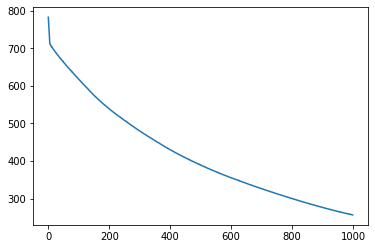

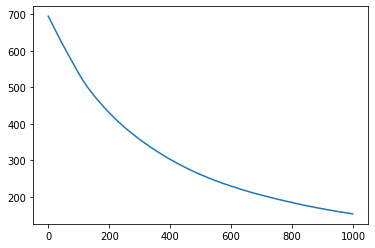

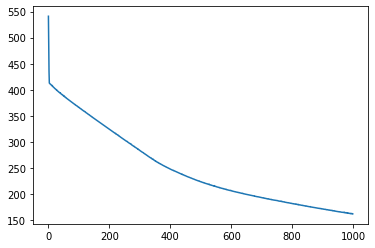

 58%|█████▊    | 7/12 [17:08<09:31, 114.39s/it]

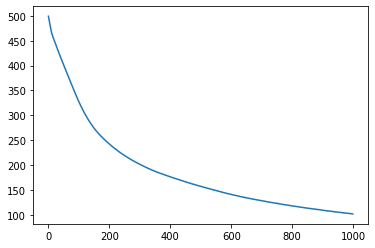

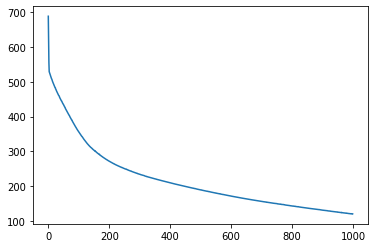

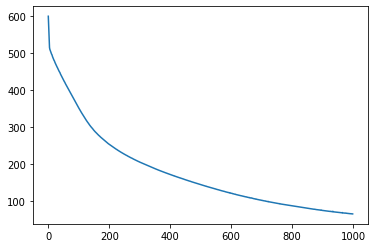

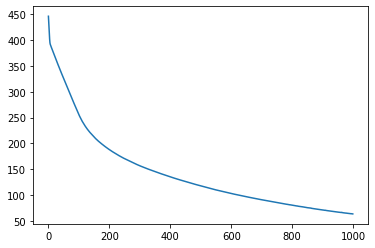

 67%|██████▋   | 8/12 [18:03<06:21, 95.37s/it] 

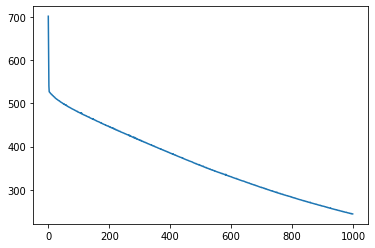

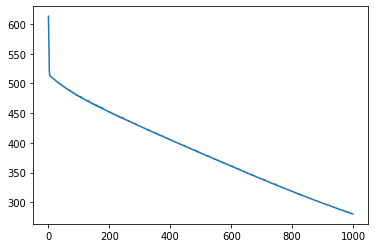

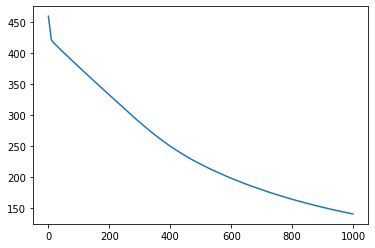

 75%|███████▌  | 9/12 [18:47<03:57, 79.26s/it]

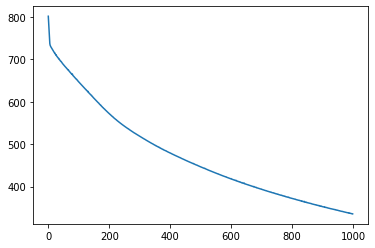

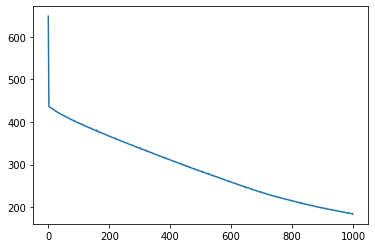

 83%|████████▎ | 10/12 [19:22<02:11, 65.70s/it]

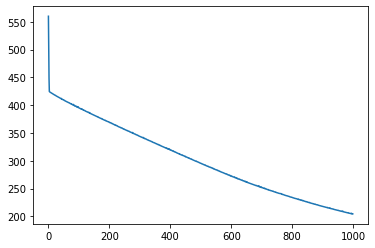

100%|██████████| 12/12 [19:36<00:00, 98.01s/it]


In [52]:
with tf.device("gpu:0"):
   print("tf.keras code in this scope will run on GPU")
   svm_classifiers = trainSVMs(image_data, labels)

In [53]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z >= 0:
        return 1
    else:
        return -1

In [54]:
def predict(x):
    
    count = np.zeros((number_of_classes,))
    
    for i in range(number_of_classes):
        for j in range(i+1, number_of_classes):
            w,b = svm_classifiers[i][j]
            
            #Take a majority prediction
            z = binaryPredict(x,w,b)
            
            if z==1:
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    return final_prediction

In [55]:
print(predict(image_data[0]))
print(labels[0])

10
1


In [56]:
def accuracy(x,y):
    
    pred = []
    count=0
    
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1
    
    return count/x.shape[0], pred

In [58]:
training_acc, ypred = accuracy(image_data, labels)
print('Training Acc:', training_acc)

val_acc, ypred = accuracy(val_data, val_labels)
print('Validation Acc:', val_acc)

Training Acc: 0.5136650315346881
Validation Acc: 0.40756302521008403


In [59]:
reverse_label_dict = {v: k for k, v in labels_dict.items()}
reverse_label_dict

{0: 'Loose Silky-bent',
 1: 'Shepherds Purse',
 2: 'Scentless Mayweed',
 3: 'Common Chickweed',
 4: 'Fat Hen',
 5: 'Common wheat',
 6: 'Sugar beet',
 7: 'Black-grass',
 8: 'Cleavers',
 9: 'Small-flowered Cranesbill',
 10: 'Charlock',
 11: 'Maize'}

In [60]:
test_labels = []
for image in test_image_data:
    prediction = predict(image)
    test_labels.append(reverse_label_dict[prediction])


out_df = pd.DataFrame({'file': test_names,'species' : test_labels})
out_df.to_csv('/content/drive/MyDrive/AI_FinalProject/SVM.csv', index=False)